# Token Selection Strategy Comparison: CLS vs Average Pooling vs Combined

This notebook compares the performance of three token selection strategies for vision transformers: CLS token only, average pooling (AP) only, and their combination (CLS + AP). 

The analysis focuses on experiments using "All layers (attentive)" across three model architectures (CLIP-B-16, DINOv2-B-14, ViT-B-16) and multiple datasets. Performance is measured as absolute accuracy gains relative to the baseline CLS last layer approach.

**Output**: A dual-panel boxplot visualization showing:
- Left panel: Overall performance distribution by token selection 
- Right panel: Per-dataset performance breakdown across all three token selections

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
from pathlib import Path
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
sys.path.append('../..')

from helper import add_additional_info, filter_df_for_best_runs, get_abs_rel_performance, load_ds_info, init_plotting_params, save_or_show
from constants import ds_info_file, BASE_PATH_PROJECT, DS_ORDER, FOLDER_SUBSTRING

In [2]:
init_plotting_params()

{
  "agg.path.chunksize": 0,
  "axes.labelsize": 13.0,
  "axes.titlesize": 14.0,
  "axes3d.trackballsize": 0.667,
  "boxplot.flierprops.markersize": 6.0,
  "boxplot.meanprops.markersize": 6.0,
  "errorbar.capsize": 0.0,
  "figure.figsize": [
    6.4,
    4.8
  ],
  "figure.labelsize": "large",
  "figure.titlesize": "large",
  "font.cursive": [
    "Apple Chancery",
    "Textile",
    "Zapf Chancery",
    "Sand",
    "Script MT",
    "Felipa",
    "Comic Neue",
    "Comic Sans MS",
    "cursive"
  ],
  "font.family": [
    "sans-serif"
  ],
  "font.fantasy": [
    "Chicago",
    "Charcoal",
    "Impact",
    "Western",
    "xkcd script",
    "fantasy"
  ],
  "font.monospace": [
    "DejaVu Sans Mono",
    "Bitstream Vera Sans Mono",
    "Computer Modern Typewriter",
    "Andale Mono",
    "Nimbus Mono L",
    "Courier New",
    "Courier",
    "Fixed",
    "Terminal",
    "monospace"
  ],
  "font.sans-serif": [
    "DejaVu Sans",
    "Bitstream Vera Sans",
    "Computer Modern Sans Serif

### Global variables

In [ ]:
project_paths = [
    BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp",
    BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp_cls_vs_ap"
]

In [ ]:
storing_path = BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp/plots/appendix_cls_vs_ap_vs_cls_n_ap"
SAVE = 'both'
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

### Gather all results

In [5]:
res = []
for project_path in project_paths:
    for res_path in project_path.rglob('seed_0/results.json'):
        
        df = pd.read_json(res_path)
        df = add_additional_info(df)
        
        model_id_n_hopt_slug = "/".join(res_path.parts[10:-1])
        df['model_id_n_hopt_slug'] = model_id_n_hopt_slug
        df['res_folder'] = project_path.name

        res.append(df)
all_results = pd.concat(res).reset_index(drop=True)

### Filter results for experiment

In [6]:
models_to_consider = ['CLIP-B-16', 'DINOv2-B-14', 'ViT-B-16']
datasets_not_to_consider = ['imagenet-subset-50k', 'wds/imagenet1k']

In [7]:
single_model_results =  all_results[
    (all_results['Experiment'] == 'CLS last layer') & \
    (all_results['base_model_fmt'].isin(models_to_consider))
    ].copy().reset_index(drop=True)
single_model_results = single_model_results[~single_model_results['dataset'].isin(datasets_not_to_consider)].reset_index(drop=True)
single_model_results = single_model_results.set_index(['dataset', 'base_model_fmt'])

In [8]:
subset_results = all_results[
    (all_results['base_model_fmt'].isin(models_to_consider)) & \
    (all_results['attention_dropout']=='[0.0, 0.1]') & \
    (all_results['Experiment'].str.contains('layers from all blocks (attentive)', regex=False))
].copy().reset_index(drop=True)

In [9]:
subset_results = subset_results[~subset_results['dataset'].isin(datasets_not_to_consider)].reset_index(drop=True)

In [10]:
metric_cols = [
    'train_lp_bal_acc1', 
    'test_lp_bal_acc1', 
]
new_metric_cols = [
    'abs_perf_gain_train_lp_bal_acc1', 
    'abs_perf_gain_test_lp_bal_acc1', 
]

In [11]:
def row_get_abs_perf_diff(row):
    ds = row['dataset']
    model = row['base_model_fmt']
    ref_vals = single_model_results.loc[(ds, model), metric_cols]
    return row[metric_cols]-ref_vals

subset_results[new_metric_cols] = subset_results.apply(row_get_abs_perf_diff, axis=1)

In [12]:
if SAVE:
    subset_results.to_pickle(storing_path / 'results_dataframe.pkl')
    print(f"Stored gathered results...")

Stored gathered results...


### Plot distribution performances

In [13]:
subset_results.loc[:,'layer_types'] = subset_results.loc[:,'layer_types'].map({'cls+avg_pool': "CLS + AP", 'avg_pool': "AP", 'cls': "CLS"})

In [14]:
subset_results.loc[:,'abs_perf_gain_test_lp_bal_acc1'] *= 100

/tmp/ipykernel_247970/2290435587.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


stored image.


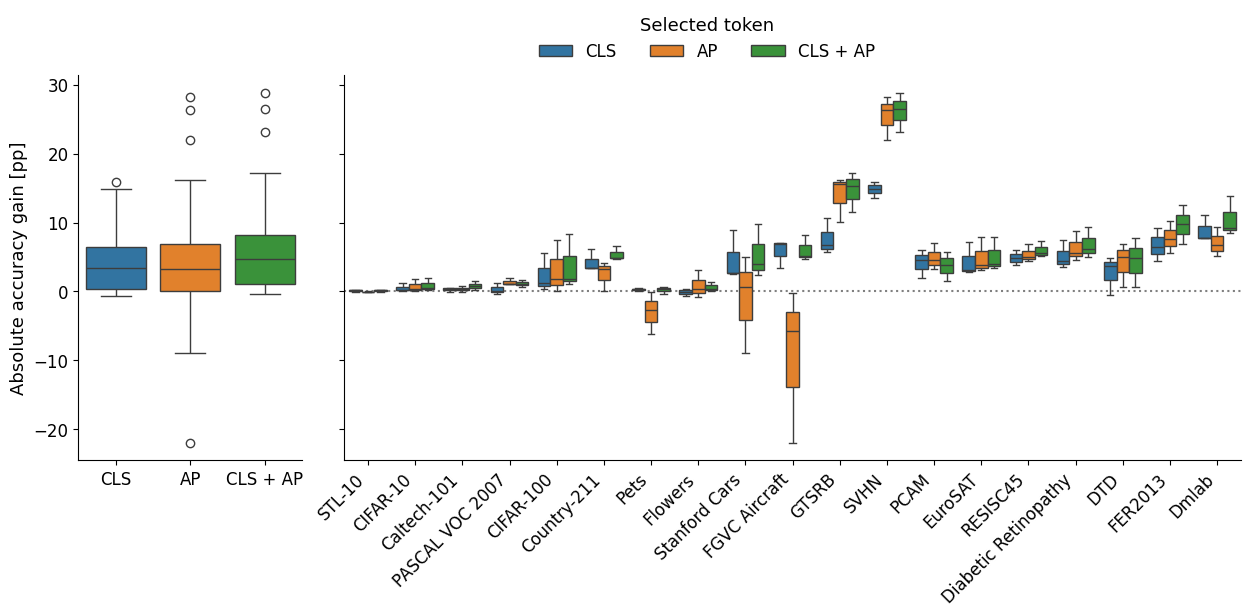

In [15]:
order = ['CLS', 'AP', 'CLS + AP']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=False,
                        gridspec_kw={'width_ratios': [1, 4], 'wspace': 0.075})

sns.boxplot(
    subset_results,
    x='layer_types',
    y='abs_perf_gain_test_lp_bal_acc1',
    hue='layer_types',
    order = order ,
    hue_order = order,
    ax=axes[0]
)

axes[0].set_xlabel("")
axes[0].set_ylabel("Absolute accuracy gain [pp]")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

sns.boxplot(
    subset_results.sort_values('dataset'),
    x='dataset_fmt',
    y='abs_perf_gain_test_lp_bal_acc1',
    hue='layer_types',
    hue_order = order,
    order = DS_ORDER,
    ax=axes[1]
)
axes[1].axhline(0, c='grey', ls=":", zorder=-1)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
sns.move_legend(axes[1], loc='lower left', bbox_to_anchor=(0.2,1), title='Selected token', frameon=False, ncols=3)
axes[1].set_xlabel("")
axes[1].set_ylabel("Absolute accuracy gain [pp]")

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


fn = storing_path / f'boxplot_v2.pdf'
save_or_show(fig, fn, SAVE)